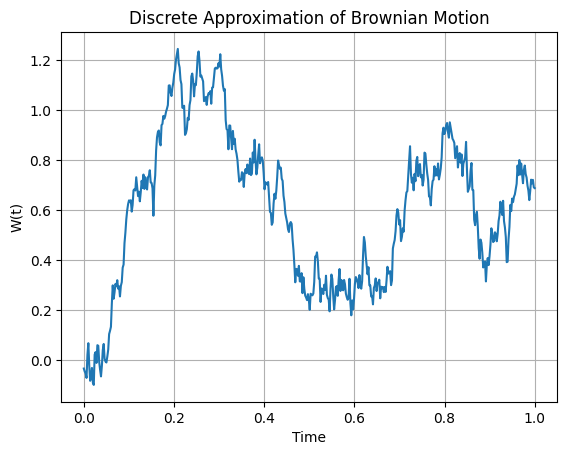

In [10]:
import numpy as np
import matplotlib.pyplot as plt

T = 1
N = 500
dt = T / N
t = np.linspace(0, T, N)
Z = np.random.normal(0, 1, N)
W = np.cumsum(np.sqrt(dt) * Z)  # Discrete Brownian motion

plt.plot(t, W)
plt.title("Discrete Approximation of Brownian Motion")
plt.xlabel("Time")
plt.ylabel("W(t)")
plt.grid(True)
plt.show()


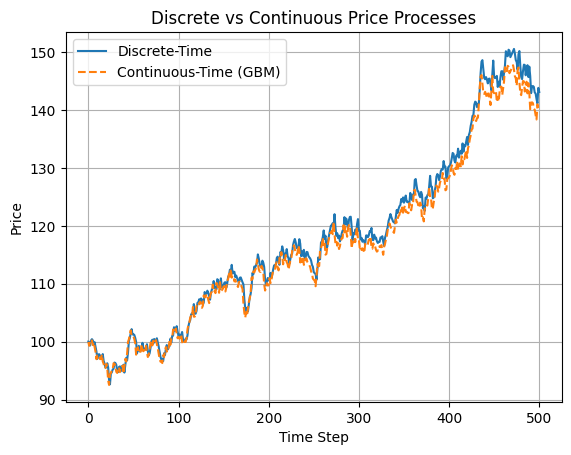

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100
T = 1
mu = 0.1
sigma = 0.2
N = 500
dt = T / N

# Discrete random walk
Z = np.random.normal(0, 1, N)
S_discrete = [S0]
for z in Z:
    S_discrete.append(S_discrete[-1] * np.exp(mu * dt + sigma * np.sqrt(dt) * z))

# Continuous approximation (Euler)
W = np.cumsum(np.sqrt(dt) * Z)
t = np.linspace(0, T, N)
S_continuous = S0 * np.exp((mu - 0.5 * sigma ** 2) * t + sigma * W)

# Plot
plt.plot(S_discrete, label='Discrete-Time')
plt.plot(S_continuous, label='Continuous-Time (GBM)', linestyle='--')
plt.legend()
plt.title("Discrete vs Continuous Price Processes")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.grid(True)
plt.show()


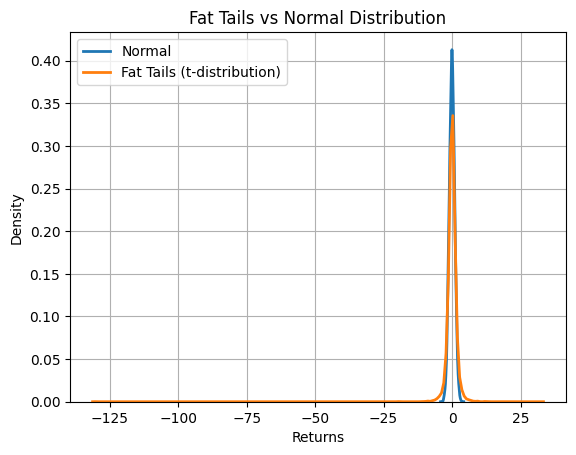

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
normal_returns = np.random.normal(0, 1, 10000)
fat_tailed_returns = np.random.standard_t(df=3, size=10000)  # t-distribution with fat tails

sns.kdeplot(normal_returns, label="Normal", linewidth=2)
sns.kdeplot(fat_tailed_returns, label="Fat Tails (t-distribution)", linewidth=2)
plt.title("Fat Tails vs Normal Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
S0 = 100
K = 100
u = 1.1
d = 0.9
r = 0.05
dt = 1
q = (np.exp(r * dt) - d) / (u - d)

# Final option values at T = 2
Suu = S0 * u * u
Sud = S0 * u * d
Sdd = S0 * d * d

Cu = max(Suu - K, 0)
Cm = max(Sud - K, 0)
Cd = max(Sdd - K, 0)

# Step back one level
C1u = np.exp(-r * dt) * (q * Cu + (1 - q) * Cm)
C1d = np.exp(-r * dt) * (q * Cm + (1 - q) * Cd)

# Step back to time 0
C0 = np.exp(-r * dt) * (q * C1u + (1 - q) * C1d)
print("Option Price:", round(C0, 2))


Option Price: 10.87


In [13]:
import numpy as np
import pandas as pd

# Parameters
S0 = 100          # Initial stock price
u = 1.1           # Up factor
d = 0.9           # Down factor
N = 3             # Number of time steps

# Initialize tree
tree = np.zeros((N+1, N+1))

# Fill the tree
for i in range(N+1):         # Time step
    for j in range(i+1):     # Number of up moves
        tree[i, j] = S0 * (u ** j) * (d ** (i - j))

# Convert to DataFrame for readability
df = pd.DataFrame(tree)
df = df.replace(0, "")
print("Binomial Asset Price Tree (N = 3):")
print(df)


Binomial Asset Price Tree (N = 3):
       0      1      2      3
0  100.0                     
1   90.0  110.0              
2   81.0   99.0  121.0       
3   72.9   89.1  108.9  133.1


In [14]:
import numpy as np

def crr_binomial_option_price(S0, K, T, r, sigma, N, option_type='call', exercise='european'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)

    # Step 1: Build asset price tree
    stock_tree = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))
    
    # Step 2: Option value at maturity
    option_tree = np.zeros_like(stock_tree)
    for j in range(N + 1):
        if option_type == 'call':
            option_tree[N, j] = max(0, stock_tree[N, j] - K)
        else:
            option_tree[N, j] = max(0, K - stock_tree[N, j])
    
    # Step 3: Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold = np.exp(-r * dt) * (p * option_tree[i + 1, j + 1] + (1 - p) * option_tree[i + 1, j])
            if exercise == 'european':
                option_tree[i, j] = hold
            else:
                # American: check early exercise
                if option_type == 'call':
                    exercise_now = max(0, stock_tree[i, j] - K)
                else:
                    exercise_now = max(0, K - stock_tree[i, j])
                option_tree[i, j] = max(hold, exercise_now)
    
    return option_tree[0, 0]


In [15]:
S0 = 100     # Initial stock price
K = 100      # Strike
T = 1        # 1 year
r = 0.05     # 5% interest
sigma = 0.2  # 20% volatility
N = 100      # 100 steps

call_price = crr_binomial_option_price(S0, K, T, r, sigma, N, option_type='call', exercise='european')
put_price = crr_binomial_option_price(S0, K, T, r, sigma, N, option_type='put', exercise='european')

print(f"European Call Price: {call_price:.4f}")
print(f"European Put Price:  {put_price:.4f}")


European Call Price: 10.4306
European Put Price:  5.5536


In [16]:
import numpy as np

def binomial_option_price(S0, K, T, r, sigma, N, option_type="call"):
    """
    Price a European option using the Cox-Ross-Rubinstein (CRR) binomial model.

    Parameters:
    S0          = initial stock price
    K           = strike price
    T           = time to maturity (in years)
    r           = risk-free rate (annual, continuous compounding)
    sigma       = volatility (annual)
    N           = number of steps
    option_type = 'call' or 'put'

    Returns:
    Option price at t = 0
    """

    # Step size
    dt = T / N
    # Up and Down factors
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    # Risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)

    # Stock prices at maturity
    ST = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])

    # Payoff at maturity
    if option_type == "call":
        payoff = np.maximum(ST - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Backward induction
    discount = np.exp(-r * dt)
    for i in range(N - 1, -1, -1):
        payoff = discount * (p * payoff[1:] + (1 - p) * payoff[:-1])

    return payoff[0]


In [17]:
# Parameters
S0 = 100     # Initial stock price
K = 100      # Strike price
T = 1        # Time to maturity (1 year)
r = 0.05     # Risk-free rate (5%)
sigma = 0.2  # Volatility (20%)
N = 3        # Number of time steps

call_price = binomial_option_price(S0, K, T, r, sigma, N, option_type="call")
put_price  = binomial_option_price(S0, K, T, r, sigma, N, option_type="put")

print(f"European Call Option Price: {call_price:.4f}")
print(f"European Put Option Price:  {put_price:.4f}")


European Call Option Price: 11.0439
European Put Option Price:  6.1668


In [18]:
import numpy as np
from math import comb, exp

def arrow_debreu_prices(N, T, r, p):
    """
    Compute Arrow-Debreu security prices at maturity for each terminal node.

    Parameters:
    N = number of steps
    T = time to maturity
    r = risk-free rate (annual)
    p = risk-neutral probability

    Returns:
    List of Arrow-Debreu prices q_j for each node j
    """
    q = []
    discount = exp(-r * T)
    for j in range(N + 1):
        prob = comb(N, j) * (p ** j) * ((1 - p) ** (N - j))
        qj = discount * prob
        q.append(qj)
    return q


In [19]:
N = 3           # Number of steps
T = 1           # Maturity = 1 year
r = 0.05        # 5% risk-free rate
p = 0.5         # Risk-neutral probability (just an example)

q = arrow_debreu_prices(N, T, r, p)
for i, qj in enumerate(q):
    print(f"Arrow-Debreu price at node {i} (with {i} up-moves): {qj:.5f}")


Arrow-Debreu price at node 0 (with 0 up-moves): 0.11890
Arrow-Debreu price at node 1 (with 1 up-moves): 0.35671
Arrow-Debreu price at node 2 (with 2 up-moves): 0.35671
Arrow-Debreu price at node 3 (with 3 up-moves): 0.11890


In [20]:
payoffs = [5, 3, 1, 0]  # From node 0 to node 3


In [21]:
price = sum([qj * pj for qj, pj in zip(q, payoffs)])


In [22]:
print(payoffs)

[5, 3, 1, 0]


In [23]:
print(price)

2.021362527064017


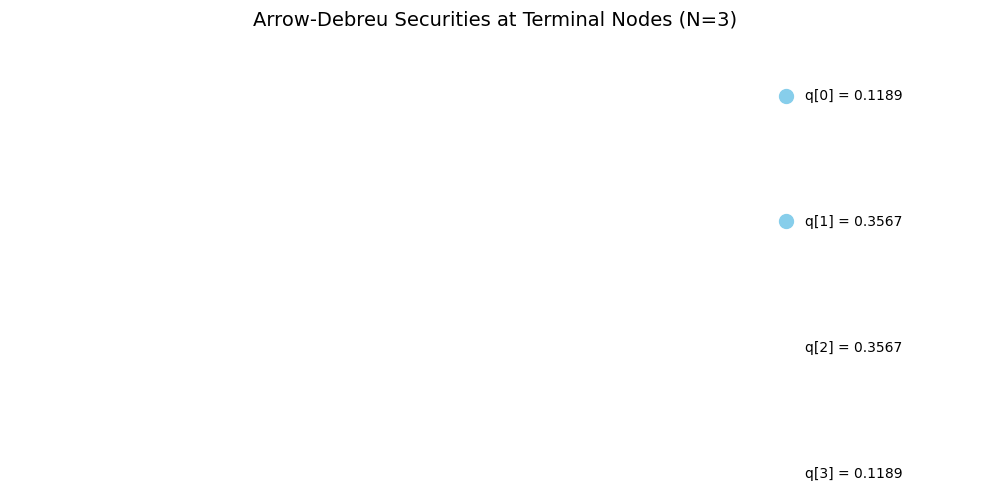

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from math import comb, exp

# Parameters
N = 3           # Number of steps
T = 1           # Time to maturity
r = 0.05        # Risk-free rate
p = 0.5         # Risk-neutral probability

# Compute Arrow-Debreu prices
def arrow_debreu_prices(N, T, r, p):
    q = []
    discount = exp(-r * T)
    for j in range(N + 1):
        prob = comb(N, j) * (p ** j) * ((1 - p) ** (N - j))
        qj = discount * prob
        q.append(qj)
    return q

q = arrow_debreu_prices(N, T, r, p)

# Plotting the binomial tree with Arrow-Debreu prices
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Arrow-Debreu Securities at Terminal Nodes (N=3)", fontsize=14)
ax.set_xlim(-1, N + 1)
ax.set_ylim(-0.5, N + 1)

# Draw nodes and values
for j in range(N + 1):
    x = N
    y = N - j * 2
    ax.plot(x, y, 'o', color='skyblue', markersize=10)
    ax.text(x + 0.1, y, f"q[{j}] = {q[j]:.4f}", fontsize=10, verticalalignment='center')

# Hide axes
ax.axis('off')

plt.tight_layout()
plt.show()


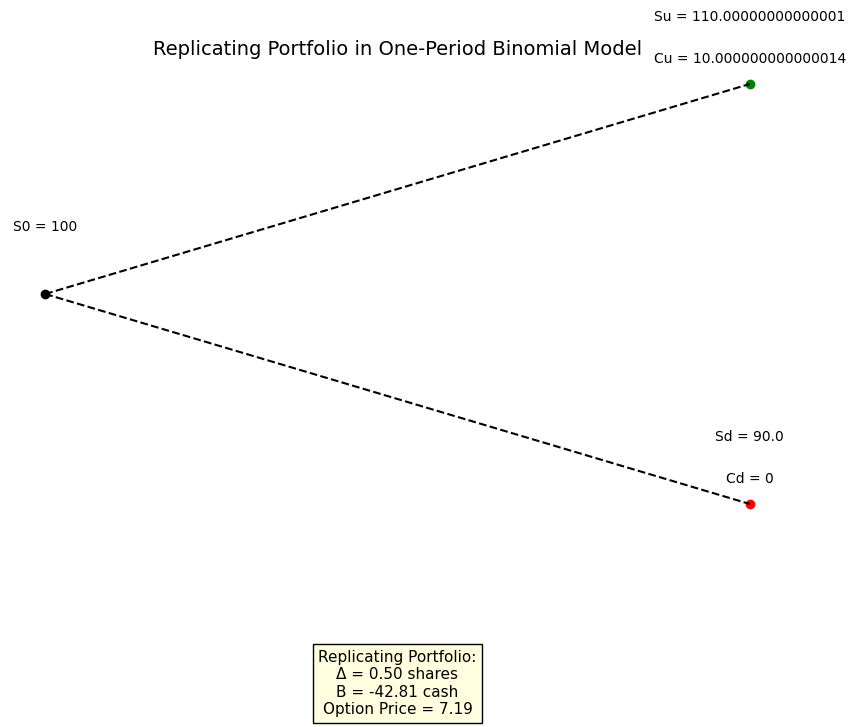

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100         # Initial stock price
K = 100          # Strike price
T = 1            # Time to maturity (in years)
r = 0.05         # Risk-free rate
u = 1.1          # Up factor
d = 0.9          # Down factor
N = 1            # One-period example
dt = T / N
R = np.exp(r * dt)

# Terminal stock prices
Su = S0 * u
Sd = S0 * d

# Terminal option payoffs for a call option
Cu = max(Su - K, 0)
Cd = max(Sd - K, 0)

# Calculate replicating portfolio
Delta = (Cu - Cd) / (Su - Sd)
B = (u * Cd - d * Cu) / (u - d) / R
C0 = Delta * S0 + B

# Visualization of Tree + Replicating Portfolio
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Replicating Portfolio in One-Period Binomial Model", fontsize=14)

# Draw nodes
ax.plot(0, 0, 'ko')
ax.text(0, 0.3, f"S0 = {S0}", ha='center', fontsize=10)

ax.plot(1, 1, 'go')
ax.text(1, 1.3, f"Su = {Su}", ha='center', fontsize=10)
ax.text(1, 1.1, f"Cu = {Cu}", ha='center', fontsize=10)

ax.plot(1, -1, 'ro')
ax.text(1, -0.7, f"Sd = {Sd}", ha='center', fontsize=10)
ax.text(1, -0.9, f"Cd = {Cd}", ha='center', fontsize=10)

# Connect nodes
ax.plot([0, 1], [0, 1], 'k--')
ax.plot([0, 1], [0, -1], 'k--')

# Show replicating portfolio
info_text = f"Replicating Portfolio:\nΔ = {Delta:.2f} shares\nB = {B:.2f} cash\nOption Price = {C0:.2f}"
ax.text(0.5, -2, info_text, ha='center', fontsize=11, bbox=dict(facecolor='lightyellow', edgecolor='black'))

# Hide axes
ax.axis('off')
plt.show()


In [27]:
import numpy as np

def binomial_option_pricing(S0, K, T, r, sigma, N, option_type="call", exercise="european"):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # 1. Initialize asset prices at maturity
    asset_prices = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    
    # 2. Compute option payoff at maturity
    if option_type == "call":
        option_values = np.maximum(asset_prices - K, 0)
    else:
        option_values = np.maximum(K - asset_prices, 0)
    
    # 3. Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            # Expected discounted value
            hold = discount * (p * option_values[j + 1] + (1 - p) * option_values[j])
            
            if exercise == "european":
                option_values[j] = hold
            else:
                # Recalculate asset price at node (i, j)
                stock_price = S0 * (u ** j) * (d ** (i - j))
                if option_type == "call":
                    exercise_now = max(stock_price - K, 0)
                else:
                    exercise_now = max(K - stock_price, 0)
                option_values[j] = max(hold, exercise_now)
    
    return option_values[0]


In [28]:
# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 3

# Prices
euro_call = binomial_option_pricing(S0, K, T, r, sigma, N, "call", "european")
amer_call = binomial_option_pricing(S0, K, T, r, sigma, N, "call", "american")

euro_put  = binomial_option_pricing(S0, K, T, r, sigma, N, "put", "european")
amer_put  = binomial_option_pricing(S0, K, T, r, sigma, N, "put", "american")

print(f"European Call:  {euro_call:.4f}")
print(f"American Call:  {amer_call:.4f}")
print(f"European Put:   {euro_put:.4f}")
print(f"American Put:   {amer_put:.4f}")


European Call:  11.0439
American Call:  11.0439
European Put:   6.1668
American Put:   6.4996


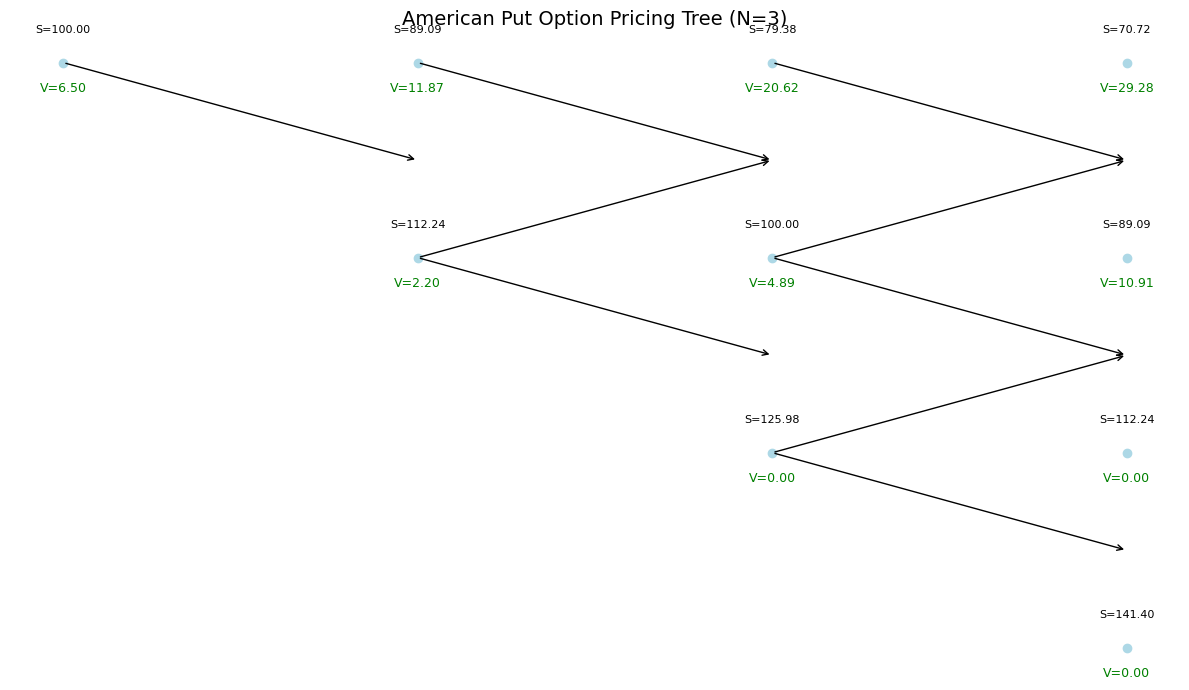

In [29]:
import matplotlib.pyplot as plt

def plot_binomial_tree(S0, K, T, r, sigma, N, option_type="call", exercise="european"):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # Initialize asset and option trees
    stock_tree = [[S0 * (u ** j) * (d ** (i - j)) for j in range(i + 1)] for i in range(N + 1)]
    option_tree = [[0] * (i + 1) for i in range(N + 1)]

    # Terminal payoffs
    for j in range(N + 1):
        S = stock_tree[N][j]
        if option_type == "call":
            option_tree[N][j] = max(S - K, 0)
        else:
            option_tree[N][j] = max(K - S, 0)
    
    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold = discount * (p * option_tree[i + 1][j + 1] + (1 - p) * option_tree[i + 1][j])
            S = stock_tree[i][j]
            if exercise == "european":
                option_tree[i][j] = hold
            else:
                if option_type == "call":
                    exercise_now = max(S - K, 0)
                else:
                    exercise_now = max(K - S, 0)
                option_tree[i][j] = max(hold, exercise_now)

    # Plot tree
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_title(f"{exercise.capitalize()} {option_type.capitalize()} Option Pricing Tree (N={N})", fontsize=14)
    ax.axis("off")

    # Positioning
    x_spacing = 1
    y_spacing = 1

    for i in range(N + 1):
        for j in range(i + 1):
            x = i * x_spacing
            y = (N - 2 * j) * y_spacing
            ax.plot(x, y, 'o', color='lightblue')
            S_val = stock_tree[i][j]
            V_val = option_tree[i][j]
            ax.text(x, y + 0.3, f"S={S_val:.2f}", ha='center', fontsize=8)
            ax.text(x, y - 0.3, f"V={V_val:.2f}", ha='center', fontsize=9, color='green')

            # Draw arrows
            if i < N:
                up_y = (N - 2 * j - 1) * y_spacing
                down_y = (N - 2 * j + 1) * y_spacing
                ax.annotate("", xy=(x + x_spacing, up_y), xytext=(x, y),
                            arrowprops=dict(arrowstyle="->", lw=1))
                ax.annotate("", xy=(x + x_spacing, down_y), xytext=(x, y),
                            arrowprops=dict(arrowstyle="->", lw=1))

    plt.tight_layout()
    plt.show()

# Example: American Put Option Visualization
plot_binomial_tree(S0=100, K=100, T=1, r=0.05, sigma=0.2, N=3, option_type="put", exercise="american")


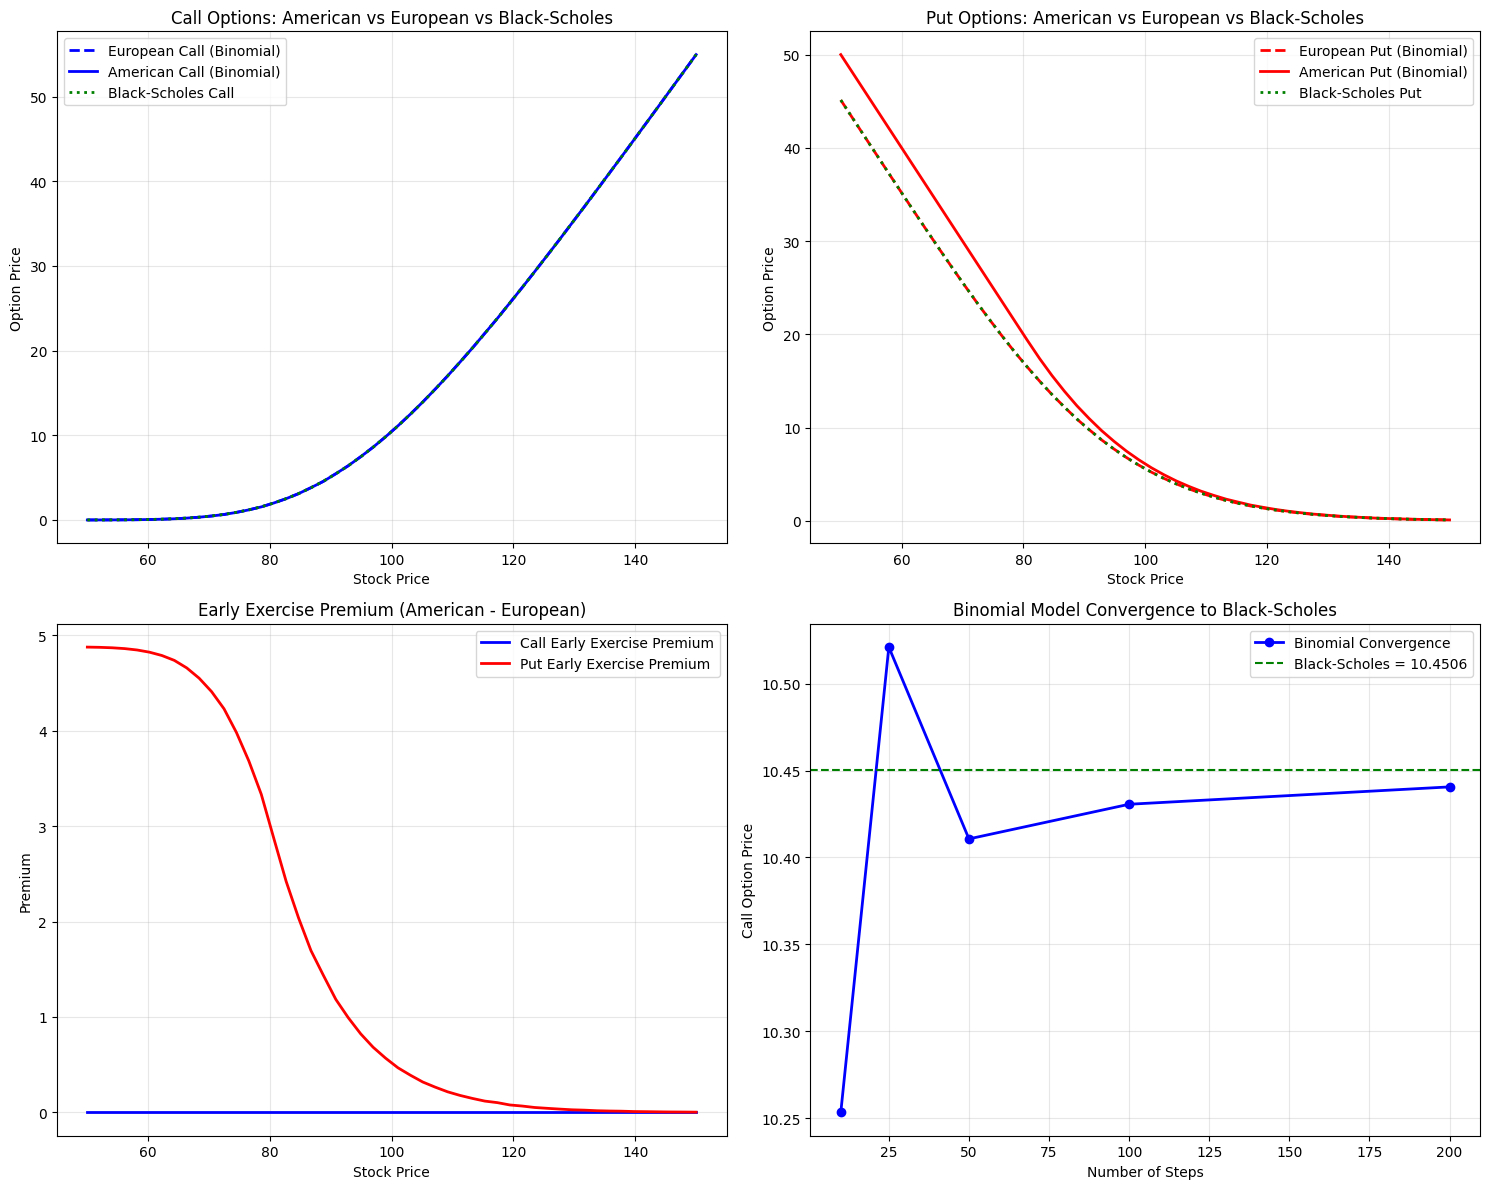

Option Pricing Comparison (S0=$100, K=$100)
European Call - Binomial: $11.1183
American Call - Binomial:  $11.1183
European Call - Black-Scholes: $11.1101
Call Early Exercise Premium: $0.0000

European Put - Binomial: $5.2208
American Put - Binomial:  $5.6889
European Put - Black-Scholes: $5.2126
Put Early Exercise Premium: $0.4681

Early Exercise Analysis for American Put:
Early exercise optimal for S0=$80
Number of early exercise nodes: 2693


In [31]:
import matplotlib.pyplot as plt
import numpy as np

def binomial_option_pricing(S0, K, T, r, sigma, N, option_type="call", exercise="european"):
    """
    Binomial option pricing model for European and American options
    
    Returns both the option price and early exercise boundary (for American options)
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # Store early exercise information
    early_exercise_boundary = []
    
    # Stock prices at maturity
    asset_prices = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    
    # Option payoffs at maturity
    if option_type == "call":
        option_values = np.maximum(asset_prices - K, 0)
    else:
        option_values = np.maximum(K - asset_prices, 0)

    # Backward induction
    for i in range(N - 1, -1, -1):
        new_option_values = np.zeros(i + 1)
        early_exercise_nodes = []
        
        for j in range(i + 1):
            hold = discount * (p * option_values[j + 1] + (1 - p) * option_values[j])
            
            if exercise == "european":
                new_option_values[j] = hold
            else:
                S = S0 * (u ** j) * (d ** (i - j))
                if option_type == "call":
                    exercise_now = max(S - K, 0)
                else:
                    exercise_now = max(K - S, 0)
                
                if exercise_now > hold:
                    new_option_values[j] = exercise_now
                    early_exercise_nodes.append((i * dt, S))
                else:
                    new_option_values[j] = hold
        
        option_values = new_option_values
        if early_exercise_nodes:
            early_exercise_boundary.extend(early_exercise_nodes)

    return option_values[0], early_exercise_boundary

# Black-Scholes formula for comparison
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """Black-Scholes formula for European options"""
    from scipy.stats import norm
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == "call":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 100

# Compute option prices
stock_prices = np.linspace(50, 150, 50)

# Calculate all option prices
euro_call = []
amer_call = []
euro_put = []
amer_put = []
bs_call = []
bs_put = []

for S in stock_prices:
    ec, _ = binomial_option_pricing(S, K, T, r, sigma, N, "call", "european")
    ac, _ = binomial_option_pricing(S, K, T, r, sigma, N, "call", "american")
    ep, _ = binomial_option_pricing(S, K, T, r, sigma, N, "put", "european")
    ap, _ = binomial_option_pricing(S, K, T, r, sigma, N, "put", "american")
    
    euro_call.append(ec)
    amer_call.append(ac)
    euro_put.append(ep)
    amer_put.append(ap)
    bs_call.append(black_scholes(S, K, T, r, sigma, "call"))
    bs_put.append(black_scholes(S, K, T, r, sigma, "put"))

# Create comprehensive plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Call Options
ax1.plot(stock_prices, euro_call, 'b--', label='European Call (Binomial)', linewidth=2)
ax1.plot(stock_prices, amer_call, 'b-', label='American Call (Binomial)', linewidth=2)
ax1.plot(stock_prices, bs_call, 'g:', label='Black-Scholes Call', linewidth=2)
ax1.set_title('Call Options: American vs European vs Black-Scholes')
ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Option Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Put Options
ax2.plot(stock_prices, euro_put, 'r--', label='European Put (Binomial)', linewidth=2)
ax2.plot(stock_prices, amer_put, 'r-', label='American Put (Binomial)', linewidth=2)
ax2.plot(stock_prices, bs_put, 'g:', label='Black-Scholes Put', linewidth=2)
ax2.set_title('Put Options: American vs European vs Black-Scholes')
ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Option Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Early Exercise Premium
call_premium = np.array(amer_call) - np.array(euro_call)
put_premium = np.array(amer_put) - np.array(euro_put)

ax3.plot(stock_prices, call_premium, 'b-', label='Call Early Exercise Premium', linewidth=2)
ax3.plot(stock_prices, put_premium, 'r-', label='Put Early Exercise Premium', linewidth=2)
ax3.set_title('Early Exercise Premium (American - European)')
ax3.set_xlabel('Stock Price')
ax3.set_ylabel('Premium')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Convergence Analysis
steps = [10, 25, 50, 100, 200]
binomial_prices = []
for n in steps:
    price, _ = binomial_option_pricing(S0, K, T, r, sigma, n, "call", "european")
    binomial_prices.append(price)

bs_price = black_scholes(S0, K, T, r, sigma, "call")
ax4.plot(steps, binomial_prices, 'bo-', label='Binomial Convergence', linewidth=2)
ax4.axhline(y=bs_price, color='g', linestyle='--', label=f'Black-Scholes = {bs_price:.4f}')
ax4.set_title('Binomial Model Convergence to Black-Scholes')
ax4.set_xlabel('Number of Steps')
ax4.set_ylabel('Call Option Price')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print numerical comparison
print("Option Pricing Comparison (S0=$100, K=$100)")
print("=" * 50)
print(f"European Call - Binomial: ${euro_call[25]:.4f}")
print(f"American Call - Binomial:  ${amer_call[25]:.4f}")
print(f"European Call - Black-Scholes: ${bs_call[25]:.4f}")
print(f"Call Early Exercise Premium: ${amer_call[25] - euro_call[25]:.4f}")
print()
print(f"European Put - Binomial: ${euro_put[25]:.4f}")
print(f"American Put - Binomial:  ${amer_put[25]:.4f}")
print(f"European Put - Black-Scholes: ${bs_put[25]:.4f}")
print(f"Put Early Exercise Premium: ${amer_put[25] - euro_put[25]:.4f}")

# Analyze early exercise boundary for American put
print("\nEarly Exercise Analysis for American Put:")
print("=" * 40)
_, early_exercise = binomial_option_pricing(80, K, T, r, sigma, N, "put", "american")
if early_exercise:
    print(f"Early exercise optimal for S0=$80")
    print(f"Number of early exercise nodes: {len(early_exercise)}")
else:
    print("No early exercise optimal for S0=$80")

ValueError: Integers to negative integer powers are not allowed.

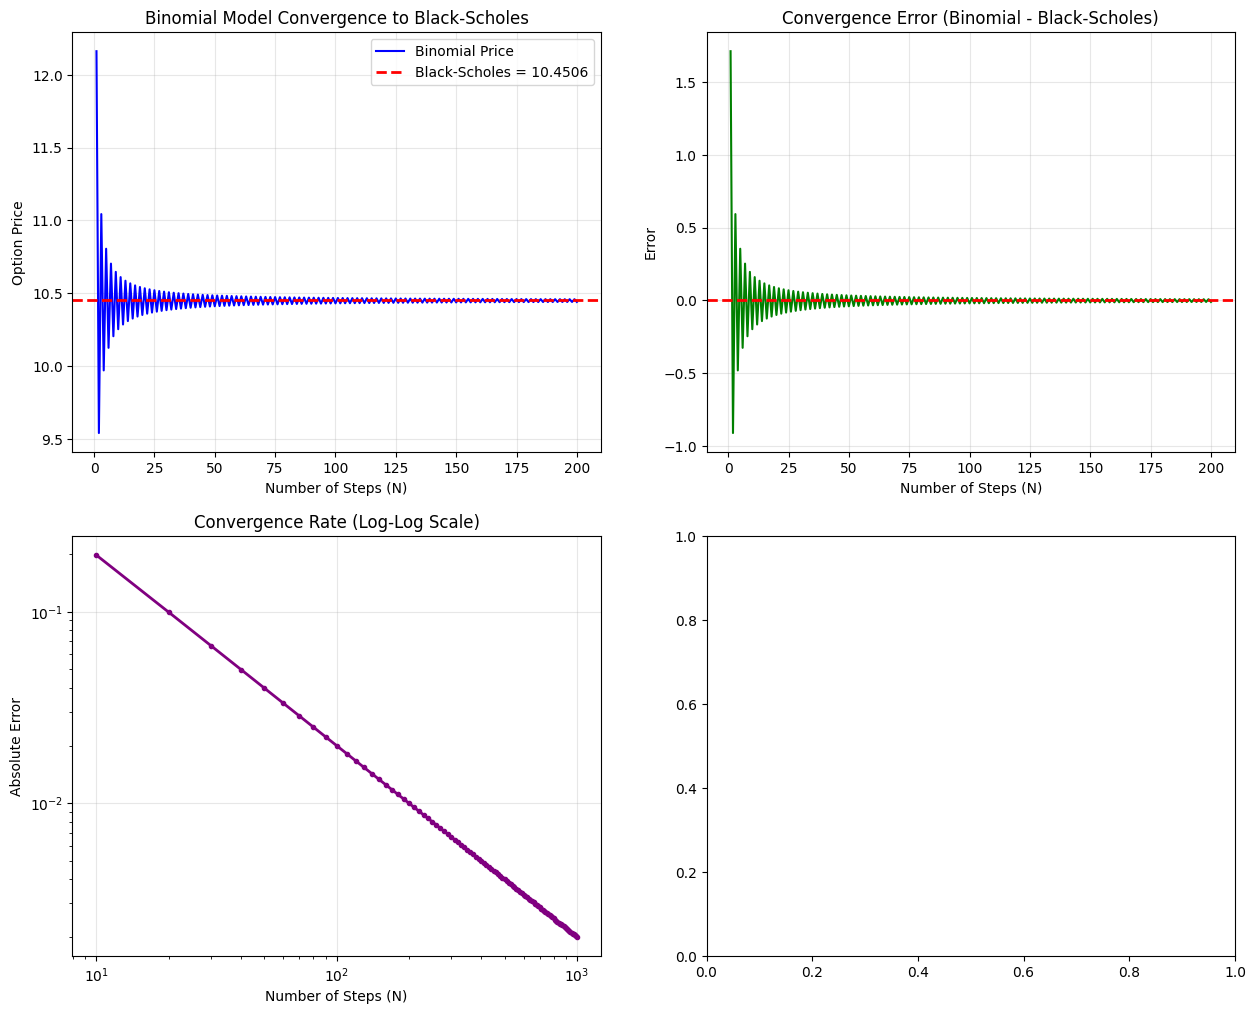

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula for European call
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Binomial model for European call option
def binomial_call(S, K, T, r, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # Terminal prices
    asset_prices = np.array([S * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    option_values = np.maximum(asset_prices - K, 0)
    
    # Backward induction
    for i in range(N - 1, -1, -1):
        option_values = discount * (p * option_values[1:i+2] + (1 - p) * option_values[0:i+1])
    
    return option_values[0]

# Parameters
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.2

# Calculate Black-Scholes price
bs_price = black_scholes_call(S, K, T, r, sigma)

# Create comprehensive analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Basic Convergence
steps = np.arange(1, 201)
binomial_prices = [binomial_call(S, K, T, r, sigma, N) for N in steps]

ax1.plot(steps, binomial_prices, 'b-', linewidth=1.5, label='Binomial Price')
ax1.axhline(bs_price, color='red', linestyle='--', linewidth=2, 
           label=f'Black-Scholes = {bs_price:.4f}')
ax1.set_title('Binomial Model Convergence to Black-Scholes')
ax1.set_xlabel('Number of Steps (N)')
ax1.set_ylabel('Option Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Convergence Error
errors = np.array(binomial_prices) - bs_price
ax2.plot(steps, errors, 'g-', linewidth=1.5)
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title('Convergence Error (Binomial - Black-Scholes)')
ax2.set_xlabel('Number of Steps (N)')
ax2.set_ylabel('Error')
ax2.grid(True, alpha=0.3)

# Plot 3: Log-scale convergence (for large N)
large_steps = np.arange(10, 1001, 10)
large_binomial_prices = [binomial_call(S, K, T, r, sigma, N) for N in large_steps]
large_errors = np.abs(np.array(large_binomial_prices) - bs_price)

ax3.loglog(large_steps, large_errors, 'purple', linewidth=2, marker='o', markersize=3)
ax3.set_title('Convergence Rate (Log-Log Scale)')
ax3.set_xlabel('Number of Steps (N)')
ax3.set_ylabel('Absolute Error')
ax3.grid(True, alpha=0.3)

# Add theoretical convergence rate line
theoretical_slope = large_steps**(-1)
theoretical_slope = theoretical_slope * (large_errors[0] / theoretical_slope[0])
ax3.loglog(large_steps, theoretical_slope, 'r--', linewidth=2, 
          label='O(1/N) theoretical rate')
ax3.legend()

# Plot 4: Oscillating behavior for small N
small_steps = np.arange(1, 51)
small_binomial_prices = [binomial_call(S, K, T, r, sigma, N) for N in small_steps]

ax4.plot(small_steps, small_binomial_prices, 'b-', linewidth=1.5, 
         marker='o', markersize=4, label='Binomial Price')
ax4.axhline(bs_price, color='red', linestyle='--', linewidth=2, 
           label=f'Black-Scholes = {bs_price:.4f}')
ax4.set_title('Oscillating Convergence (Small N)')
ax4.set_xlabel('Number of Steps (N)')
ax4.set_ylabel('Option Price')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Numerical analysis
print("Binomial to Black-Scholes Convergence Analysis")
print("=" * 50)
print(f"Black-Scholes Price: ${bs_price:.6f}")
print()

# Show convergence at specific points
test_points = [10, 25, 50, 100, 200, 500, 1000]
print("Convergence at specific points:")
print("-" * 35)
for n in test_points:
    bin_price = binomial_call(S, K, T, r, sigma, n)
    error = bin_price - bs_price
    print(f"N={n:4d}: Price=${bin_price:.6f}, Error={error:+.6f}")

# Analyze oscillation pattern
print("\nOscillation Analysis (first 20 steps):")
print("-" * 40)
for n in range(1, 21):
    bin_price = binomial_call(S, K, T, r, sigma, n)
    error = bin_price - bs_price
    direction = "Above" if error > 0 else "Below"
    print(f"N={n:2d}: ${bin_price:.4f} ({direction} BS by {abs(error):.4f})")

# Calculate convergence statistics
final_100_errors = np.array([binomial_call(S, K, T, r, sigma, n) - bs_price 
                            for n in range(901, 1001)])
print(f"\nConvergence Statistics (N=901-1000):")
print(f"Mean absolute error: {np.mean(np.abs(final_100_errors)):.6f}")
print(f"Standard deviation: {np.std(final_100_errors):.6f}")
print(f"Max absolute error: {np.max(np.abs(final_100_errors)):.6f}")

# Show computational efficiency
import time
print(f"\nComputational Efficiency:")
print("-" * 25)
for n in [100, 500, 1000]:
    start_time = time.time()
    price = binomial_call(S, K, T, r, sigma, n)
    end_time = time.time()
    error = abs(price - bs_price)
    print(f"N={n:4d}: Time={end_time-start_time:.4f}s, Error={error:.6f}")

# Black-Scholes computation time
start_time = time.time()
bs_price_timed = black_scholes_call(S, K, T, r, sigma)
end_time = time.time()
print(f"Black-Scholes: Time={end_time-start_time:.6f}s (analytical solution)")